In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import copy
import os
import random
import shutil
import warnings

from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings (optional)
warnings.filterwarnings("ignore")

print("Imported Completely!")  # Fixed spelling


Imported Completely!


In [4]:
import os

# Check the files in the Kaggle dataset directory
data_dir = "/kaggle/input"
print(os.listdir(data_dir))


['chest-ctscan-images']


In [5]:


data_dir = "/kaggle/input"
dataset_folder = "chest-ctscan-images"

print(os.listdir(f"{data_dir}/{dataset_folder}"))




['Data']


In [6]:


base_dir = "/kaggle/input/chest-ctscan-images"
print(os.listdir(base_dir))


['Data']


Load dataset using ImageFolder

In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((380, 380)),  # EfficientNet-B4 default input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = ImageFolder(root=base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check sample
images, labels = next(iter(dataloader))
print(images.shape, labels.shape)


torch.Size([32, 3, 380, 380]) torch.Size([32])


Define Transformations
EfficientNet-B4 expects 380x380 images with ImageNet normalization.

Augmentation and Normalization 
Data augmented using torchvision.transforms.

In [8]:
from PIL import Image  # Import Image module from PIL

# Load a sample image
image_path = "/kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000108 (3).png"
image = Image.open(image_path).convert("RGB")  # Convert RGBA/Grayscale to RGB

# Apply transformations
transformed_image = transform(image)


Now preprocessing for the entire dataset as it's working for single sample image

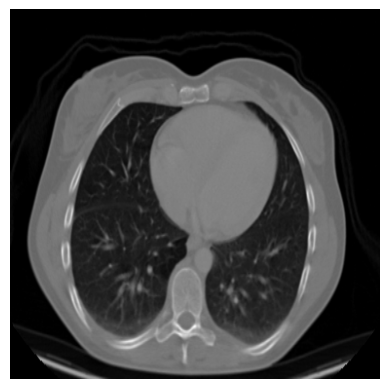

In [9]:
import matplotlib.pyplot as plt

# Convert the tensor image back to NumPy for visualization
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

denorm_image = denormalize(transformed_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

plt.imshow(denorm_image.permute(1, 2, 0))  # Rearrange dimensions for Matplotlib
plt.axis("off")
plt.show()


In [10]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define dataset paths
train_dir = "/kaggle/input/chest-ctscan-images/Data/train"
valid_dir = "/kaggle/input/chest-ctscan-images/Data/valid"
test_dir = "/kaggle/input/chest-ctscan-images/Data/test"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((380, 380)),  # Resize for EfficientNet-B4
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])


Load the Dataset Using ImageFolder


In [11]:
# Load dataset using ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
batch_size = 16  # Adjust batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Validation dataset: {len(valid_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")


Train dataset: 613 images
Validation dataset: 72 images
Test dataset: 315 images


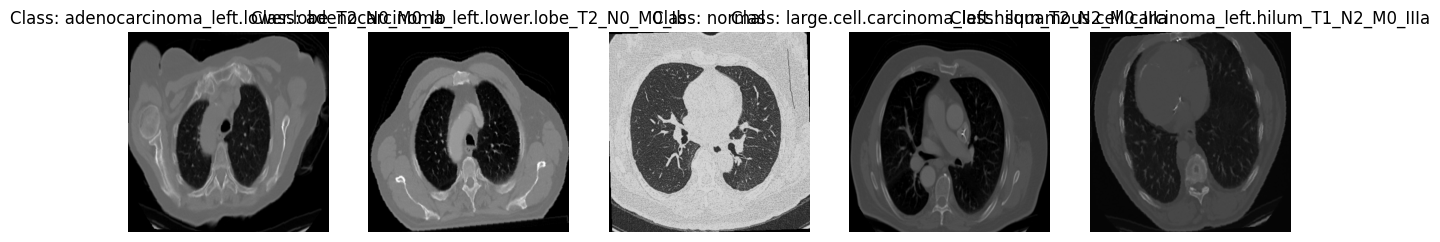

In [12]:
import matplotlib.pyplot as plt
import torch

# Get class labels from ImageFolder
class_names = train_dataset.classes  # ['adenocarcinoma', 'large cell adenocarcinoma', 'normal', 'squamous carcinoma']

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Function to denormalize and convert tensor to NumPy for visualization
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Display images with class labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = denormalize(images[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"Class: {class_names[labels[i]]}")  # Assign class label as caption
    axes[i].axis("off")

plt.show()


Loading pretrained efficienet B4 model

In [13]:
import torch
torch.cuda.empty_cache()


In [14]:
# Load pretrained EfficientNet-B4 model
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

# Modify the classifier (last layer) to match the number of classes (4)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4)  # 4 output classes

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model architecture
print(model)




#weights=models.EfficientNet_B4_Weights.DEFAULT → Loads pretrained ImageNet weights.
#Replaces last FC layer (classifier[1]) with a Linear() layer having 4 output classes.
#Moves model to GPU for faster training.

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 196MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

Define Loss Function & Optimizer

In [15]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR over time


#CrossEntropyLoss → Used for multi-class classification.
#Adam optimizer → Adapts learning rate dynamically for better convergence.
#StepLR scheduler → Reduces learning rate after 5 epochs (gamma=0.1 slows learning)

Train on your Dataset

In [16]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam or another suitable one)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 50  

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    scheduler.step()  # Adjust learning rate

print("Training complete!")


Epoch [1/50], Loss: 34.2266, Accuracy: 63.30%
Epoch [2/50], Loss: 14.1750, Accuracy: 87.93%
Epoch [3/50], Loss: 6.8828, Accuracy: 94.62%
Epoch [4/50], Loss: 4.8085, Accuracy: 95.92%
Epoch [5/50], Loss: 7.1912, Accuracy: 95.27%
Epoch [6/50], Loss: 3.5777, Accuracy: 97.06%
Epoch [7/50], Loss: 4.1706, Accuracy: 96.25%
Epoch [8/50], Loss: 1.7120, Accuracy: 99.02%
Epoch [9/50], Loss: 1.3644, Accuracy: 98.86%
Epoch [10/50], Loss: 0.9505, Accuracy: 99.35%
Epoch [11/50], Loss: 1.1690, Accuracy: 99.35%
Epoch [12/50], Loss: 1.2412, Accuracy: 98.86%
Epoch [13/50], Loss: 0.4230, Accuracy: 100.00%
Epoch [14/50], Loss: 0.4926, Accuracy: 99.84%
Epoch [15/50], Loss: 0.6058, Accuracy: 99.51%
Epoch [16/50], Loss: 0.8335, Accuracy: 99.35%
Epoch [17/50], Loss: 0.4407, Accuracy: 99.67%
Epoch [18/50], Loss: 1.0667, Accuracy: 98.86%
Epoch [19/50], Loss: 0.6875, Accuracy: 99.35%
Epoch [20/50], Loss: 0.7642, Accuracy: 99.51%
Epoch [21/50], Loss: 0.4987, Accuracy: 99.67%
Epoch [22/50], Loss: 0.8724, Accuracy: 9

In [18]:
torch.save(model.state_dict(), "/kaggle/working/efficientnet_b4_weights.pth")
